In [1]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from utils import remove_all_ticks_and_labels
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

# device = 'cpu'
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}', flush=True)

Using device: cpu


what are the effects of an architecture with skip connections?

In [348]:
from utils import save_model_weights
from dataset_utils import load_trimodal_data, load_unimodal_data, load_unimodal_data_3d, load_unimodal_data_nd, generate_2d_swiss_roll
from models import VariableDendriticCircuit, VariableDendriticCircuitWithSkipConnections

# ---------------------------------- params ---------------------------------- #
dataset_size = 2e3
num_ambient_dims = 2
num_hiddens = [
        [2, 2, 2, 2, 2, 2, 2, 2, 3, 3],
        [3, 3, 3, 3, 3, 3, 4],
        [4, 4, 4, 4, 4, 3],
        [5, 5, 5, 5, 5],
        [8, 8, 7, 7],
        [59, 59]
    ]
num_hidden = num_hiddens[3]
bias=True

# ------------------------------ define dataset ------------------------------ #
dataset = generate_2d_swiss_roll(dataset_size, rescaled=True, return_as_tensor=True)[1]
# dataset = load_unimodal_data_nd(dataset_size, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)

# -------------------------------- load model -------------------------------- #
model_sc = VariableDendriticCircuitWithSkipConnections(
    hidden_cfg=num_hidden, 
    num_in=num_ambient_dims, 
    num_out=num_ambient_dims, 
    bias=bias
)

model = VariableDendriticCircuit(
    hidden_cfg=num_hidden, 
    num_in=num_ambient_dims, 
    num_out=num_ambient_dims, 
    bias=bias
)

# print(num_hidden)

In [318]:
print(model)
print(model_sc)

VariableDendriticCircuit(
  (nonlin): ReLU()
  (features): MySequential(
    (0): NoiseConditionalLinearConcat1(
      (linear): Linear(in_features=3, out_features=6250, bias=True)
    )
    (1): ReLU()
    (2): DendriticBranchLayer()
    (3): ReLU()
    (4): DendriticBranchLayer()
    (5): ReLU()
    (6): DendriticBranchLayer()
    (7): ReLU()
    (8): DendriticBranchLayer()
    (9): ReLU()
    (10): DendriticBranchLayer()
  )
)
VariableDendriticCircuitWithSkipConnections(
  (nonlin): ReLU()
  (fc_layer): MySequential(
    (0): NoiseConditionalLinearConcat1(
      (linear): Linear(in_features=3, out_features=6250, bias=True)
    )
    (1): ReLU()
  )
  (features): MySequential(
    (0): DendriticBranchLayerWithSkipConnections()
    (1): ReLU()
    (2): DendriticBranchLayerWithSkipConnections()
    (3): ReLU()
    (4): DendriticBranchLayerWithSkipConnections()
    (5): ReLU()
    (6): DendriticBranchLayerWithSkipConnections()
    (7): ReLU()
    (8): DendriticBranchLayerWithSkipConnect

In [319]:
# model.features[2].layer_weights.shape
print(model.features[0].linear.weight.shape)
print(model.features[2].layer_weights.shape)

print(model_sc.fc_layer[0].linear.weight.shape)
print(model_sc.features[0].layer_weights[:, :-3].shape)

print('yes')
for feature in model_sc.features:   
    if hasattr(feature, 'layer_weights'):
        print('has attr')
        print(feature.layer_weights.shape)

torch.Size([6250, 3])
torch.Size([1250, 6])
torch.Size([6250, 3])
torch.Size([1250, 5])
yes
has attr
torch.Size([1250, 8])
has attr
torch.Size([250, 8])
has attr
torch.Size([50, 8])
has attr
torch.Size([10, 8])
has attr
torch.Size([2, 8])


In [349]:
model = model_sc

# train

In [350]:
# ------------------------------ training params ----------------------------- #
num_steps = 100
forward_schedule = 'sigmoid'
num_epochs = 10000+1
batch_size = 512
lr = 3e-3
l1_reg = .001
l1_on_basal_only = True

from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from prior_utils import forward_process
from utils import noise_estimation_loss

coefs = forward_process(num_steps, device, forward_schedule)
betas, alphas, alphas_prod, alphas_prod_p, alphas_bar_sqrt, one_minus_alphas_prod_log, one_minus_alphas_prod_sqrt = coefs
alphas_bar_sqrt = alphas_bar_sqrt.to(device)
one_minus_alphas_prod_sqrt = one_minus_alphas_prod_sqrt.to(device)

# training set
dataset = dataset.to(device)
model.to(device)

# training parameteres
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
model_name = 'VDC'
model_number = 1
run_dir = os.path.join(base_dir, 'demos/runs', f'{model_name}_{model_number}')
tb = SummaryWriter(run_dir)
losses = []
# start_time = time.time()

# start training
model.train()
for t in tqdm(range(int(num_epochs)), total=int(num_epochs), desc='Training model', unit='epochs', miniters=int(num_epochs)/1000, maxinterval=float("inf")):
    permutation = torch.randperm(dataset.size()[0], device=device)

    for i in range(0, dataset.size()[0], batch_size):
        # retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        
        # compute the loss
        loss = noise_estimation_loss(model, batch_x, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', l1_reg=l1_reg, l1_on_basal_only=l1_on_basal_only, has_class_label=False)
        # zero the gradients
        optimizer.zero_grad()
        # backward pass: compute the gradient of the loss wrt the parameters
        loss.backward()
        # call the step function to update the parameters
        optimizer.step()

    # write to tensorboard
    # print(loss.item())
    tb.add_scalar('Loss', loss.item(), t)
    losses.append(loss.item())
tb.flush()

Training model:   0%|          | 0/10001 [00:00<?, ?epochs/s]

[29.049999237060547, 50.88898468017578, 13.457731246948242, 12.91369342803955, 14.861534118652344, 5.688018321990967, 3.7283833026885986, 2.7784221172332764, 1.6764105558395386, 1.7972888946533203, 1.7628240585327148, 1.5477420091629028, 1.256603717803955, 1.145118236541748, 1.1485426425933838, 0.9663490056991577, 0.893593430519104, 0.9377099871635437, 0.9489033222198486, 0.8736993670463562, 0.9361115097999573, 0.865745484828949, 0.8544403314590454, 0.877739667892456, 0.9062767028808594, 0.8913627862930298, 0.918715238571167, 0.8266096115112305, 0.8787043690681458, 0.8650439381599426, 0.8633944392204285, 0.8582815527915955, 0.8187398314476013, 0.8448784351348877, 0.8241612911224365, 0.8476848006248474, 0.845054030418396, 0.8938356041908264, 0.8588052988052368, 0.9172220826148987, 0.8340246677398682, 0.8362157344818115, 0.8174571990966797, 0.7582626938819885, 0.9364146590232849, 0.771881639957428, 0.7989894151687622, 0.7913125157356262, 0.8425595164299011, 0.8383075594902039, 0.83304280

[None]

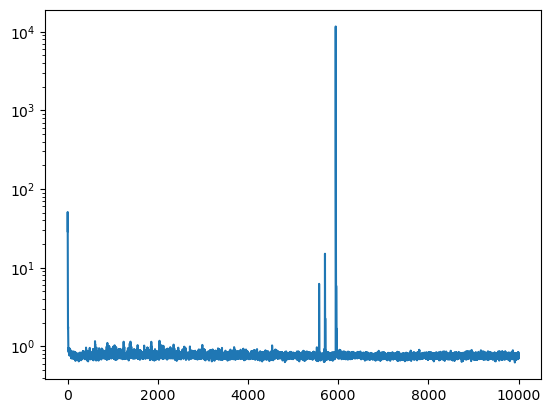

In [351]:
print(losses)
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set(yscale='log')
# ax.set(yscale='log', ylim=[6e1, 1e2])
# ax.set(yscale='log', ylim=[0, 100])

In [352]:
model

VariableDendriticCircuitWithSkipConnections(
  (nonlin): ReLU()
  (fc_layer): MySequential(
    (0): NoiseConditionalLinearConcat1(
      (linear): Linear(in_features=3, out_features=6250, bias=True)
    )
    (1): ReLU()
  )
  (features): MySequential(
    (0): DendriticBranchLayerWithSkipConnections()
    (1): ReLU()
    (2): DendriticBranchLayerWithSkipConnections()
    (3): ReLU()
    (4): DendriticBranchLayerWithSkipConnections()
    (5): ReLU()
    (6): DendriticBranchLayerWithSkipConnections()
    (7): ReLU()
    (8): DendriticBranchLayerWithSkipConnections()
  )
)

(6250, 3)
-3.9141796 1.933416
-0.5310987 0.019709986


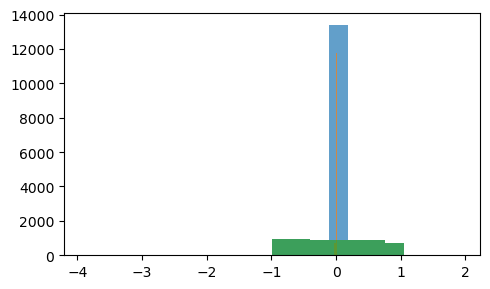

In [356]:
# histogram of the weights
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

if isinstance(model, VariableDendriticCircuit):
    weights = model.features[0].linear.weight.cpu().detach().numpy()
    print(weights.shape)
    basal_weights_only = weights[:, :2]
    phase_weights_only = weights[:, -1:]

    ax.hist(weights.flatten(), bins=20, alpha=0.7)
    ax.hist(basal_weights_only.flatten(), bins=20, alpha=0.7)
    ax.hist(phase_weights_only.flatten(), bins=20, alpha=0.7)
    fig.tight_layout()
    print(min(weights.flatten()), max(weights.flatten()))
    print(min(basal_weights_only.flatten()), max(basal_weights_only.flatten()))
elif isinstance(model, VariableDendriticCircuitWithSkipConnections):
    fc_weights = model.fc_layer[0].linear.weight.cpu().detach().numpy()
    print(fc_weights.shape)
    basal_weights_only = fc_weights[:, :2]
    phase_weights_only = fc_weights[:, -1:]

    ax.hist(fc_weights.flatten(), bins=20, alpha=0.7)
    ax.hist(basal_weights_only.flatten(), bins=20, alpha=0.7)
    ax.hist(phase_weights_only.flatten(), bins=20, alpha=0.7)
    fig.tight_layout()
    print(min(fc_weights.flatten()), max(fc_weights.flatten()))
    print(min(basal_weights_only.flatten()), max(basal_weights_only.flatten()))
    

# inference

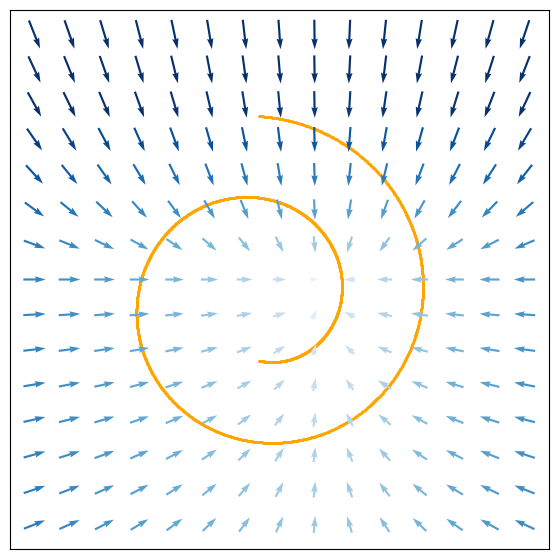

In [354]:
# plot the scores
from dataset_utils import generate_2d_swiss_roll
# num_samples_in_gt_manifold = 1e3
# dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)[1]

# ----------------- calculate flow field for diffusion model ----------------- #
from utils import select_model
# prior_sampler = select_model('unconditional-dendritic-4-layers', 1)[0]
prior_sampler = model

lim=1.5
num_vectors_per_dim=15
from likelihood_utils import calculate_prior_score_flow_field
score_xs, score_ys, color = calculate_prior_score_flow_field(prior_sampler, lim, num_vectors_per_dim, t=0, device=device)

# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
manifold = dataset.cpu()
ax.scatter(*manifold[:, :2].T, s=1, alpha=1, c='orange')
q = ax.quiver(np.linspace(-lim, lim, num_vectors_per_dim), np.linspace(-lim, lim, num_vectors_per_dim), 
          score_xs, score_ys, 
          color,
          cmap='Blues',
          angles='xy', scale_units='xy', pivot='mid',
        #   scale=12,  # 47
          scale=6,
          clim=(0, 1))
ax.set_aspect('equal')
from utils import remove_all_ticks_and_labels
_=remove_all_ticks_and_labels(ax)

from plot import save_fig
# save_fig(fig, 'figure2-prior')

<Axes: >

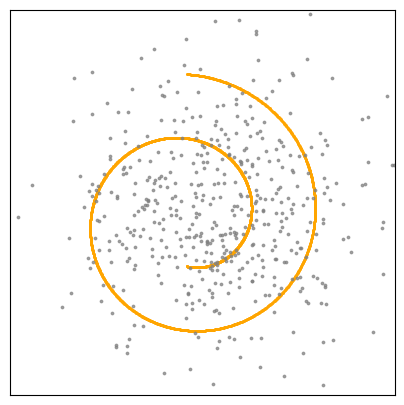

In [355]:
# generate samples
# now generate samples from all models for a given epoch
lim = 1.5
lims = [-lim, lim]
sample_size = int(5e2)
ambient_dims = 2
from prior_utils import p_sample_loop

fig, ax = plt.subplots(1, 1, figsize=(5,5))
x_rev = p_sample_loop(model, (sample_size, ambient_dims), num_steps, device, normalized_beta_schedule=False)
x_rev = x_rev.cpu().detach().numpy()
ax.scatter(*manifold.T, s=1, color='orange')
ax.scatter(*x_rev[-1].T, s=3, alpha=0.7, color='grey')  

ax.set_aspect('equal')
ax.set(xlim=lims, ylim=lims)
remove_all_ticks_and_labels(ax)


# 3d manifold in 10d ambient space

In [381]:
from utils import save_model_weights
from dataset_utils import load_trimodal_data, load_unimodal_data, load_unimodal_data_3d, load_unimodal_data_nd, generate_2d_swiss_roll
from models import VariableDendriticCircuit, VariableDendriticCircuitWithSkipConnections

# ---------------------------------- params ---------------------------------- #
dataset_size = 2e3
num_ambient_dims = 10
num_hiddens = [
        [2, 2, 2, 2, 2, 2, 2, 2, 3, 3],
        [3, 3, 3, 3, 3, 3, 4],
        [4, 4, 4, 4, 4, 3],
        [5, 5, 5, 5, 5],
        [8, 8, 7, 7],
        [59, 59]
    ]
num_hidden = num_hiddens[-4]
bias=True

# ------------------------------ define dataset ------------------------------ #
# dataset = generate_2d_swiss_roll(dataset_size, rescaled=True, return_as_tensor=True)[1]
dataset = load_unimodal_data_nd(dataset_size, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)

# -------------------------------- load model -------------------------------- #
has_skip_connections = True

if has_skip_connections:
    model = VariableDendriticCircuitWithSkipConnections(
        hidden_cfg=num_hidden, 
        num_in=num_ambient_dims, 
        num_out=num_ambient_dims, 
        bias=bias
    )
else:
    model = VariableDendriticCircuit(
        hidden_cfg=num_hidden, 
        num_in=num_ambient_dims, 
        num_out=num_ambient_dims, 
        bias=bias
    )

# print(num_hidden)

size of the training set is 2000


In [382]:
# ------------------------------ training params ----------------------------- #
num_steps = 100
forward_schedule = 'sigmoid'
num_epochs = 1000+1
batch_size = 512
lr = 3e-3
l1_reg = .001
l1_on_basal_only = True

from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from prior_utils import forward_process
from utils import noise_estimation_loss

coefs = forward_process(num_steps, device, forward_schedule)
betas, alphas, alphas_prod, alphas_prod_p, alphas_bar_sqrt, one_minus_alphas_prod_log, one_minus_alphas_prod_sqrt = coefs
alphas_bar_sqrt = alphas_bar_sqrt.to(device)
one_minus_alphas_prod_sqrt = one_minus_alphas_prod_sqrt.to(device)

# training set
dataset = dataset.to(device)
model.to(device)

# training parameteres
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
model_name = 'VDC'
model_number = 1
run_dir = os.path.join(base_dir, 'demos/runs', f'{model_name}_{model_number}')
tb = SummaryWriter(run_dir)
losses = []
# start_time = time.time()

# start training
model.train()
for t in tqdm(range(int(num_epochs)), total=int(num_epochs), desc='Training model', unit='epochs', miniters=int(num_epochs)/1000, maxinterval=float("inf")):
    permutation = torch.randperm(dataset.size()[0], device=device)

    for i in range(0, dataset.size()[0], batch_size):
        # retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        
        # compute the loss
        loss = noise_estimation_loss(model, batch_x, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', l1_reg=l1_reg, l1_on_basal_only=l1_on_basal_only, has_class_label=False)
        # zero the gradients
        optimizer.zero_grad()
        # backward pass: compute the gradient of the loss wrt the parameters
        loss.backward()
        # call the step function to update the parameters
        optimizer.step()

    # write to tensorboard
    # print(loss.item())
    tb.add_scalar('Loss', loss.item(), t)
    losses.append(loss.item())
tb.flush()

Training model:   0%|          | 0/1001 [00:00<?, ?epochs/s]

[563.3529663085938, 453.8082580566406, 393.4146728515625, 349.6405944824219, 312.7975769042969, 277.157958984375, 254.14646911621094, 223.849365234375, 202.99139404296875, 180.37738037109375, 161.0516357421875, 149.0194854736328, 140.57406616210938, 135.61305236816406, 131.22708129882812, 127.43211364746094, 123.05601501464844, 117.44976806640625, 112.57054138183594, 108.41329956054688, 104.35299682617188, 100.97103118896484, 96.88362121582031, 92.7520980834961, 89.14872741699219, 85.98204040527344, 82.91305541992188, 79.73887634277344, 76.58940124511719, 73.29945373535156, 70.45545959472656, 67.66511535644531, 64.69610595703125, 62.19270324707031, 59.481117248535156, 56.82644271850586, 54.47283935546875, 52.07286834716797, 49.68307113647461, 47.41957473754883, 45.242427825927734, 43.06971740722656, 40.9551887512207, 38.97867965698242, 37.01325607299805, 35.122798919677734, 33.2886962890625, 31.535747528076172, 29.81389808654785, 28.1636962890625, 26.527917861938477, 24.963228225708008

[None]

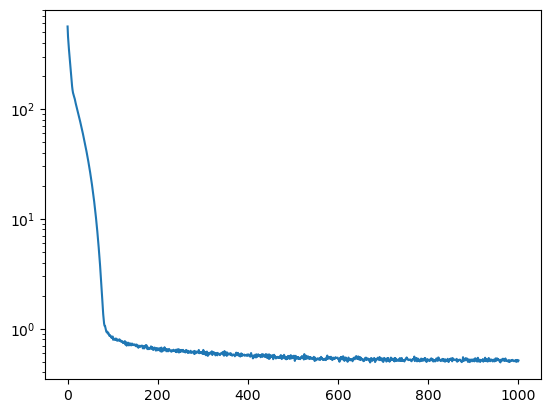

In [383]:
print(losses)
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set(yscale='log')
# ax.set(yscale='log', ylim=[6e1, 1e2])
# ax.set(yscale='log', ylim=[0, 100])

(30720, 11)
-1.9582704 1.2343497
-0.3074013 0.16366881


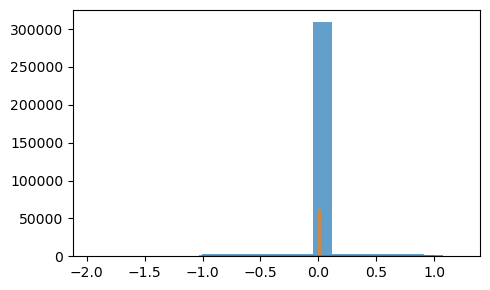

In [384]:
# histogram of the weights
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

if isinstance(model, VariableDendriticCircuit):
    weights = model.features[0].linear.weight.cpu().detach().numpy()
    print(weights.shape)
    basal_weights_only = weights[:, :2]
    phase_weights_only = weights[:, -1:]

    ax.hist(weights.flatten(), bins=20, alpha=0.7)
    ax.hist(basal_weights_only.flatten(), bins=20, alpha=0.7)
    ax.hist(phase_weights_only.flatten(), bins=20, alpha=0.7)
    fig.tight_layout()
    print(min(weights.flatten()), max(weights.flatten()))
    print(min(basal_weights_only.flatten()), max(basal_weights_only.flatten()))
elif isinstance(model, VariableDendriticCircuitWithSkipConnections):
    fc_weights = model.fc_layer[0].linear.weight.cpu().detach().numpy()
    print(fc_weights.shape)
    basal_weights_only = fc_weights[:, :2]
    phase_weights_only = fc_weights[:, -1:]

    ax.hist(fc_weights.flatten(), bins=20, alpha=0.7)
    ax.hist(basal_weights_only.flatten(), bins=20, alpha=0.7)
    ax.hist(phase_weights_only.flatten(), bins=20, alpha=0.7)
    fig.tight_layout()
    print(min(fc_weights.flatten()), max(fc_weights.flatten()))
    print(min(basal_weights_only.flatten()), max(basal_weights_only.flatten()))
    

In [385]:
# generate samples
# now generate samples from all models for a given epoch
lim = 1.5
lims = [-lim, lim]
sample_size = int(5e2)
ambient_dims = 10
from prior_utils import p_sample_loop

# fig, ax = plt.subplots(1, 1, figsize=(5,5))
x_rev = p_sample_loop(model, (sample_size, ambient_dims), num_steps, device, normalized_beta_schedule=False)
x_rev = x_rev.cpu().detach().numpy()
print(x_rev.shape)
# ax.scatter(*manifold.T, s=1, color='orange')
# ax.scatter(*x_rev[-1].T, s=3, alpha=0.7, color='grey')  

# ax.set_aspect('equal')
# ax.set(xlim=lims, ylim=lims)
# remove_all_ticks_and_labels(ax)

(101, 500, 10)


(2, 10)
size of the training set is 2000
(2, 500)


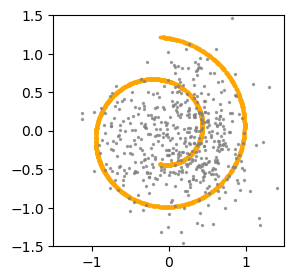

In [386]:
# the basis vectors are rotated by np.pi/4 around each pair of axes 

# ------------------------ construct the basis vectors ----------------------- #
original_basis = np.eye(10)[(0, 2), :]

# rotate the basis vectors by np.pi/4 for each dimension
from dataset_utils import rotate_manifold
n_dims = 10
theta = np.pi/4
rotated_basis = original_basis
# for every axis pair, rotate the vector by angle theta
for i in range(0, n_dims-1):
    for j in range(i+1, n_dims):
        rotated_basis = rotate_manifold(rotated_basis, n_dims, i, j, theta)
rotated_basis = np.array(rotated_basis)
print(rotated_basis.shape)


# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.set(aspect='equal', xlim=lims, ylim=lims)
# remove_all_ticks_and_labels(ax)

# project the rotated dataset on the rotated basis vectors
rotated_dataset = load_unimodal_data_nd(dataset_size, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)
rotated_dataset = rotated_dataset.detach().cpu().numpy()
projected_rotated_dataset = rotated_basis @ rotated_dataset.T
ax.scatter(*projected_rotated_dataset, s=3, c='orange')

# now project the model output onto these rotated basis vectors
model_output = x_rev[100][:500, :]
projected_model_output = rotated_basis @ model_output.T
print(projected_model_output.shape)
ax.scatter(*projected_model_output, s=2, c='grey', alpha=0.7)


In [3]:

def construct_model_name(manifold_type, num_hidden, has_skip_connections, l1_lambda, l1_on_basal_only):
    model_name = f'unconditional-dendritic'
    
    if manifold_type == '2d_swiss_roll':
        model_name = model_name
    elif manifold_type == '3d_swiss_roll':
        model_name = f'{model_name}-3d_manifold-10d_ambient'
    
    model_name = f'{model_name}-{num_hidden}-layers'
    
    if has_skip_connections:
        model_name = f'{model_name}-with-skip-conns'
    
    model_name = f'{model_name}-l1-reg={l1_lambda}'
    model_name = f'{model_name}-l1_on_basal_only={l1_on_basal_only}'
    return model_name

manifold_type = '3d_swiss_roll'
num_hidden = [5, 5, 5, 5, 5]
has_skip_connections = True
l1_lambda = 0.001
l1_on_basal_only = True
model_name = construct_model_name(manifold_type, len(num_hidden), has_skip_connections, l1_lambda, l1_on_basal_only)
print(model_name)

unconditional-dendritic-3d_manifold-10d_ambient-5-layers-with-skip-conns-l1-reg=0.001-l1_on_basal_only=True
